## Combine 2017 calendar-year drug deaths with historic data

In [17]:
import pandas as pd
from datetime import datetime

In [45]:
from census import Census
from us import states
from private import KEY

c = Census(KEY,year="2016")
c.acs5.get(('NAME', 'B01003_001E'),
           {'for': 'state:{}'.format(states.CT.fips)})

[{u'B01003_001E': 3588570.0, u'NAME': 'Connecticut', u'state': '09'}]

### Get Census population data

In [503]:
# Get population of each town
# This API was really poorly documented
# https://beta.dataweb.rm.census.gov/data/2015/acs/acs5/groups/B01003.html
POP_GROUP = "B01003_001E"
pops = pd.DataFrame(c.acs5.state_county_subdivision(('NAME', POP_GROUP),
                                states.CT.fips,
                                Census.ALL,
                                Census.ALL))
pops = pops.set_index(["NAME"])
pops = pops[[POP_GROUP]]
pops.columns = ["population"]
pops.head()

,population
NAME,
"County subdivisions not defined, Fairfield County, Connecticut",0.0
"Bethel town, Fairfield County, Connecticut",19369.0
"Bridgeport town, Fairfield County, Connecticut",147022.0
"Brookfield town, Fairfield County, Connecticut",16970.0
"Danbury town, Fairfield County, Connecticut",83890.0


In [504]:
# state level 
POP_GROUP = "B01003_001E"
state_pops = pd.DataFrame(c.acs5.state(('NAME', POP_GROUP),
                                states.CT.fips))
state_pops = state_pops.set_index(["NAME"])
state_pops = state_pops[[POP_GROUP]]
state_pops.columns = ["population"]
state_pops.head()

,population
NAME,
Connecticut,3588570.0


In [506]:
1038 * 10000 / 3588570.0

2.8925170750466065

### Get Census Race data

I'm only going to pull black, white and hispanic for race comparison

In [ ]:
# state race
state_race = pd.DataFrame(c.acs5.state_county_subdivision(('NAME', group),
                                                          states.CT.fips,

In [508]:
"""
Get the racial/ethnic makeup of each town
 
 Documentation: https://beta.dataweb.rm.census.gov/data/2016/acs/acs5/groups/B03002.html
 
 * White alone - B03002_003E
 * White, MOE - B03002_003M
 * Black, alone - B03002_004E
 * Black, MOE - B03002_004M
 * Hispanic any - B03002_012E
 * Hispanic, MOE - B03002_012M

"""

def get_race():
    
        cols = {
            "White alone":"B03002_003E",
            "White, MOE":"B03002_003M",
            "Black, alone":"B03002_004E",
            "Black, MOE":"B03002_004M",
            "Hispanic any":"B03002_012E",
            "Hispanic, MOE":"B03002_012M"
        }
        
        
        combined = None
        for k in cols:
            group = cols[k]
            df = pd.DataFrame(c.acs5.state(('NAME', group),
                                           states.CT.fips))

#             df = pd.DataFrame(c.acs5.state_county_subdivision(('NAME', group),
#                                                           states.CT.fips,
#                                                           Census.ALL,
#                                                           Census.ALL))
            df = df[["NAME",group]].set_index("NAME")
            df.columns = [k]
            
            if combined is None:
                combined = df
            else:
                combined = combined.join(df)
            
        return combined
racedf = get_race()
racedf = racedf[~(racedf.index.str.contains("not defined"))]
racedf.head()

,"Hispanic, MOE","Black, alone","Black, MOE",White alone,"White, MOE",Hispanic any
NAME,,,,,,
Connecticut,-555555555.0,347674.0,1972.0,2464450.0,1118.0,537728.0


In [509]:
import re

def town_name(tstr):
    return re.split(" town,",tstr)[0].strip().upper()
    #return tstr
    
pops.index = pops.index.map(town_name)
racedf.index = racedf.index.map(town_name)
racedf  

,"Hispanic, MOE","Black, alone","Black, MOE",White alone,"White, MOE",Hispanic any
CONNECTICUT,-555555555.0,347674.0,1972.0,2464450.0,1118.0,537728.0


In [510]:
OD["Race"].value_counts()

White                     2430
Hispanic, White            318
Black                      241
Unknown                     13
Asian, Other                11
Hispanic, Black              9
Other                        6
Asian Indian                 3
Chinese                      2
Native American, Other       1
Hawaiian                     1
Name: Race, dtype: int64

In [511]:
OD2017["Race"].value_counts()

White              813
Hispanic, White    114
Black               88
Hispanic, Black      8
Asian Indian         6
Unknown              3
Asian, Other         3
Other                1
Name: Race, dtype: int64

### Import 2012-mid 2017 data

In [512]:
OD_URL = "https://data.ct.gov/api/views/rybz-nyjw/rows.csv?accessType=DOWNLOAD"
OD = pd.read_csv(OD_URL)

In [10]:
len(OD)

3583

In [11]:
OD.head()

,CaseNumber,Date,Sex,Race,Age,Residence City,Residence State,Residence County,Death City,Death State,...,Benzodiazepine,Methadone,Amphet,Tramad,Morphine (not heroin),Other,Any Opioid,MannerofDeath,AmendedMannerofDeath,DeathLoc
0,13-16336,11/09/2013,Female,White,53.0,GROTON,NaN,NEW LONDON,GROTON,NaN,...,Y,NaN,NaN,NaN,NaN,NaN,NaN,Accident,NaN,"GROTON, CT\n(41.343693, -72.07877)"
1,12-18447,12/29/2012,Male,White,30.0,WOLCOTT,NaN,NEW HAVEN,WATERBURY,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Accident,NaN,"WATERBURY, CT\n(41.554261, -73.043069)"
2,14-2758,02/18/2014,Male,White,43.0,ENFIELD,NaN,NaN,ENFIELD,NaN,...,Y,NaN,NaN,NaN,NaN,NaN,NaN,Accident,NaN,"ENFIELD, CT\n(41.976501, -72.591985)"
3,14-13497,09/07/2014,Female,White,24.0,WALLINGFORD,NaN,NaN,WALLINGFORD,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Accident,NaN,"WALLINGFORD, CT\n(41.454408, -72.818414)"
4,13-14421,10/04/2013,Female,White,26.0,WEST HAVEN,NaN,NEW HAVEN,WEST HAVEN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Accident,NaN,"WEST HAVEN, CT\n(41.272336, -72.949817)"


### Import calendar 2017 data

In [24]:
OD2017 = pd.read_excel("data/Accident drug 2017 totals 3-1-18  website.xlsx")
OD2017.head()

,Date Reported,Sex,Race,Age,Residence City,Residence State,Residence County,Death City,Death State,Death County,...,Hydr-Cod,Benzo's,Methadone,Amphet,Tramad,Hydromorphone,Morphine (not heroin),Other,Opiate NOS,MannerofDeath
0,2017-01-01,Female,White,35,Prospect,CT,New Haven,Bristol,CT,Hartford,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Accident
1,2017-05-06,Male,White,45,Stafford,CT,Tolland,Stafford,CT,Tolland,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Accident
2,2017-03-06,Male,White,33,Meriden,CT,New Haven,Meriden,CT,New Haven,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Accident
3,2017-01-02,Male,White,54,Hamden,CT,New Haven,New Haven,CT,New Haven,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Accident
4,2017-01-03,Female,White,45,New London,CT,New London,New London,CT,New London,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Accident


### Damn, the columns don't match!

In [25]:
def not_in(a, b):
    for c in a.columns:
        if c not in b.columns: print c

In [27]:
not_in(OD, OD2017)

CaseNumber
Date
ImmediateCauseA
Oxycodone
Oxymorphone
EtOH
Hydrocodone
Benzodiazepine
Any Opioid
AmendedMannerofDeath
DeathLoc


In [28]:
not_in(OD2017, OD)

Date Reported
LocationifOther
InjuryCity
injuryCounty
InjuryState
Death Certificate
Fentanyl Analogue
OxyC
OxyM
Ethanol
Hydr-Cod
Benzo's
Hydromorphone
Opiate NOS


In [109]:
print OD.columns

Index([u'CaseNumber', u'Date', u'Sex', u'Race', u'Age', u'Residence City',
       u'Residence State', u'Residence County', u'Death City', u'Death State',
       u'Death County', u'Location', u'DescriptionofInjury', u'InjuryPlace',
       u'ImmediateCauseA', u'Heroin', u'Cocaine', u'Fentanyl', u'Oxycodone',
       u'Oxymorphone', u'EtOH', u'Hydrocodone', u'Benzodiazepine',
       u'Methadone', u'Amphet', u'Tramad', u'Morphine (not heroin)', u'Other',
       u'Any Opioid', u'MannerofDeath', u'AmendedMannerofDeath', u'DeathLoc'],
      dtype='object')


In [110]:
print OD2017.columns

Index([u'Date Reported', u'Sex', u'Race', u'Age', u'Residence City',
       u'Residence State', u'Residence County', u'Death City', u'Death State',
       u'Death County', u'Location', u'LocationifOther',
       u'DescriptionofInjury', u'InjuryPlace', u'InjuryCity', u'injuryCounty',
       u'InjuryState', u'Death Certificate', u'Heroin', u'Cocaine',
       u'Fentanyl', u'Fentanyl Analogue', u'OxyC', u'OxyM', u'Ethanol',
       u'Hydr-Cod', u'Benzo's', u'Methadone', u'Amphet', u'Tramad',
       u'Hydromorphone', u'Morphine (not heroin)', u'Other', u'Opiate NOS',
       u'MannerofDeath'],
      dtype='object')


### Convert time columns from strings

In [15]:
datetime.strptime("11/09/2013","%m/%d/%Y")

datetime.datetime(2013, 11, 9, 0, 0)

In [140]:
import numpy as np

def convert_date(dstr):
    
    if dstr is None: return dstr
    #if np.isnan(dstr): return dstr
    
    try:
        return datetime.strptime(dstr,"%m/%d/%Y")
    except:
        print dstr

### Remove 2017 stuff from historical data frame

So that it can be used in conjunction with new 2017 data

In [147]:
#OD2017["Date Reported"].apply(convert_date)
OD2017["datetime"] = OD2017["Date Reported"]

In [162]:
# Remove deaths prior to Jan 1, 2017
# Make sure it ends in 2016
OD = OD[OD["datetime"] < datetime(2017,1,1)]
OD.sort_values(by="datetime",ascending=False).head(3)

,CaseNumber,Date,Sex,Race,Age,Residence City,Residence State,Residence County,Death City,Death State,...,Methadone,Amphet,Tramad,Morphine (not heroin),Other,Any Opioid,MannerofDeath,AmendedMannerofDeath,DeathLoc,datetime
2216,16-2749,12/31/2016,Male,White,57.0,NAUGATUCK,NaN,NEW HAVEN,NAUGATUCK,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Accident,NaN,"NAUGATUCK, CT\n(41.491113, -73.056564)",2016-12-31
2611,16-2902,12/31/2016,Female,White,27.0,EAST HAVEN,NaN,NEW HAVEN,EAST HAVEN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Accident,NaN,"EAST HAVEN, CT\n(41.277971, -72.871954)",2016-12-31
2538,16-2652,12/31/2016,Male,"Hispanic, White",22.0,BRISTOL,NaN,HARTFORD,BRISTOL,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Accident,NaN,"BRISTOL, CT\n(41.673037, -72.945791)",2016-12-31


In [163]:
OD["datetime"] = OD["Date"].apply(convert_date)

In [164]:
# Make sure OD2017 only includes 2017 
OD2017.sort_values(by="datetime",ascending=True).head()

,Date Reported,Sex,Race,Age,Residence City,Residence State,Residence County,Death City,Death State,Death County,...,Benzo's,Methadone,Amphet,Tramad,Hydromorphone,Morphine (not heroin),Other,Opiate NOS,MannerofDeath,datetime
0,2017-01-01,Female,White,35,Prospect,CT,New Haven,Bristol,CT,Hartford,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Accident,2017-01-01
161,2017-01-02,Male,"Hispanic, White",53,Hartford,CT,Hartford,Hartford,CT,Hartford,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Accident,2017-01-02
3,2017-01-02,Male,White,54,Hamden,CT,New Haven,New Haven,CT,New Haven,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Accident,2017-01-02
11,2017-01-02,Male,White,53,Torrington,CT,Litchfield,Torrington,CT,Litchfield,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Accident,2017-01-02
4,2017-01-03,Female,White,45,New London,CT,New London,New London,CT,New London,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Accident,2017-01-03


In [169]:
OD2017["Residence City"] = OD2017["Residence City"].apply(lambda x: str(x).upper().strip())

In [175]:
OD2017["Sex"].value_counts()

Male      777
Female    260
Name: Sex, dtype: int64

In [179]:
float(OD2017["Sex"].value_counts()["Male"]) / float(OD2017["Sex"].value_counts()["Female"])

2.9884615384615385

In [178]:
float(OD["Sex"].value_counts()["Male"]) / float(OD["Sex"].value_counts()["Female"])

2.681598062953995

In [494]:
OD["Race"].value_counts()

White                     2430
Hispanic, White            318
Black                      241
Unknown                     13
Asian, Other                11
Hispanic, Black              9
Other                        6
Asian Indian                 3
Chinese                      2
Native American, Other       1
Hawaiian                     1
Name: Race, dtype: int64

In [495]:
def race_eth(racestr):
    clean = str(racestr).upper().strip()
    if "HISPANIC" in clean: return "Hispanic"
    if "WHITE" in clean: return "White"
    if "BLACK" in clean: return "Black"
    return "Other"

In [496]:
OD["race_eth"] = OD["Race"].apply(race_eth)
OD2017["race_eth"] = OD2017["Race"].apply(race_eth)

In [194]:
towns = pops.index.unique()

### Clean town names

Adjusted for population.

In [198]:
OD2017["Residence State"].value_counts()

town_report = OD2017[OD2017["Residence State"] == "CT"]

town_report["Residence State"].value_counts()

CT    955
Name: Residence State, dtype: int64

In [199]:
len(OD2017)

1038

In [200]:
OD2017["Residence State"].value_counts()

CT    955
MA     10
NY     10
RI      2
NJ      2
SD      1
SC      1
IL      1
AL      1
CA      1
CO      1
PA      1
TX      1
FL      1
Name: Residence State, dtype: int64

In [312]:
# Look for any towns not in census
def print_problem_names(df,col="Residence City"):
    for t in df[col]:
        if t not in towns: print t
            
print_problem_names(town_report)

SUDBURY
STAFFORD SPRINGS
AMSTON
BREWSTER
BROAD BROOK
UNCASVILLE
PALMER
TARIFFVILLE
MOOSUP
WINGDALE
JEWETT CITY
SOUTH GLASTONBURY
HURLEY
nan
nan
nan
STANFORDVILLE
ALFRED STATION
nan
nan
WILLACOOCHEE
MYSTIC
COLUMBUS
ARLINGTON HEIGHTS
ONECO
AVENTURA
NEW BEDFORD
WILLIMANTIC
RYE
GALES FERRY
EAST CANAAN
NEW CASTLE
NIANTIC
WILLIMANTIC
NEW BRIT
MOOSUP
nan
JEWETT CITY
PAWCATUCK
WINSTED
nan
nan
NIANTIC
HANCOCK
DOVER PLAINS
DANIELSON
STAFFORD SPGS
nan
SAKEM
WINSTED
UNIONVILLE
TAFTVILLE
nan
OAKVILLE
nan
nan
S GLASTONBURY
STAFFORD SPRINGS
nan
N HAVEN
ROCKVILLE
WILLIMANTIC
OSHKOSH
PITTSBURGH
NORTH GROSVENORDALE
nan
nan
nan
ROCKVILLE
nan
nan
nan
WELLESLEY
JASPER
nan
nan
UNIONVILLE
NO HAVEN
MYSTIC
DANIELSON
BALTIC
nan
nan
TARIFFVILLE
PORTCHESTER
OAKDALE
GALES FERRY
IVORYTON
nan
nan
FLUSHING
SAUGUS
nan
OAKDALE
JEWETT CITY
nan
DAYVILLE
PAWCATUCK
WILLIMANTIC
NEW YORK
nan
UNCASVILLE
NORTHFORD
VERNON ROCKVL
nan
OAKDALE
MOOSUP
OAKVILLE
NEW YORK
WILLIMANTIC
nan
nan
DEER LODGE
VINE GROVE
TERRYVILLE
RYE
PORT C

In [206]:
towns[towns.contain]

Index([u'COUNTY SUBDIVISIONS NOT DEFINED, FAIRFIELD COUNTY, CONNECTICUT',
       u'BETHEL', u'BRIDGEPORT', u'BROOKFIELD', u'DANBURY', u'DARIEN',
       u'EASTON', u'FAIRFIELD', u'GREENWICH', u'MONROE',
       ...
       u'HAMPTON', u'KILLINGLY', u'PLAINFIELD', u'POMFRET', u'PUTNAM',
       u'SCOTLAND', u'STERLING', u'THOMPSON', u'WINDHAM', u'WOODSTOCK'],
      dtype='object', length=173)

In [238]:
# Fix town names
town_aliases = pd.read_csv("https://docs.google.com/spreadsheets/d/1WqZIGk2AkHXKYvd4uXy5a2nwyg5\
29e7mMU5610Ale0g/pub?gid=0&single=true&output=csv")
town_aliases.columns = ["name","real_name"]
town_aliases.head()

,name,real_name
0,ABINGTON,POMFRET
1,ADDISON,GLASTONBURY
2,ALLENTOWN,PLYMOUTH
3,ALLINGTOWN,WEST HAVEN
4,ALMYVILLE,PLAINFIELD


In [259]:
def clean_town_name(town_name):
    tmp = str(town_name).strip().upper()
    
    # QUICK FIX: Will have to add to name alias spreadsheet
    if tmp == "VERNON-ROCKVILLE": return "VERNON"
    
    if tmp not in town_aliases["name"].unique(): 
        return tmp
    return town_aliases[town_aliases["name"] == tmp].iloc[0]["real_name"]

town_report["TOWN"] = town_report["Residence City"].apply(clean_town_name)

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [315]:
#print_problem_names(town_report,"TOWN")

### Create town report

In [292]:
town_report = pd.concat([OD[["datetime","Residence City","Residence State"]],
                        OD2017[["datetime","Residence City","Residence State"]]])

In [294]:
len(town_report)

4081

In [295]:
town_report["Residence State"].value_counts()

CT    2054
NY      18
MA      18
NJ       5
FL       4
CA       2
IL       2
TX       2
RI       2
SC       1
CO       1
AL       1
SD       1
MN       1
LA       1
PA       1
OH       1
GA       1
Name: Residence State, dtype: int64

In [353]:
# Make sure we didn't duplicate anything 
len(town_report[town_report["datetime"] >= datetime(2017,1,1)])

1038

In [354]:
town_report["year"] = town_report["datetime"].apply(lambda x: x.year)

In [355]:
town_report.groupby("year").agg({"year":np.size})

,year
year,
2012,355
2013,490
2014,558
2015,723
2016,917
2017,1038


In [370]:
ct_town_report = town_report[((town_report["Residence State"].isnull()) | (town_report["Residence State"] == "CT")) & (town_report["Residence City"].notnull())]

In [371]:
ct_town_report["TOWN"] = ct_town_report["Residence City"].apply(clean_town_name)

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [372]:
ct_town_report = ct_town_report[ct_town_report["TOWN"].notnull()]
print_problem_names(ct_town_report, "TOWN")

SUDBURY
PALMER
HURLEY
STANFORDVILLE
ALFRED STATION
WILLACOOCHEE
AVENTURA
NEW BEDFORD
RYE
NEW CASTLE
DOVER PLAINS
SAKEM
OSHKOSH
PITTSBURGH
WELLESLEY
JASPER
PORTCHESTER
FLUSHING
NEW YORK
NEW YORK
DEER LODGE
VINE GROVE
RYE
PORT CHESTER
NORTH SALEM
ZIONSVILLE
KINGSTON
ALLSTON
SARATOGA SPGS
HAMPTON BAYS
CHARLESTOWN
ASTORIA
CHESAPEAKE
PORT CHESTER
MILLERTON
PAWTUCKET
MAHOPAC
HAMILTON
WINGDALE
EAST MEADOW
QUINCY
WEST  HAVEN
GRANVILLE
SANTA CRUZ
BASS HARBOR
KNOXVILLE
ORLANDO
JACKSON
HOUSTON
PASSAIC
WHITE PLAINS
NEWPORT
RED HOOK
CHEPACHET
HODGDON
CLAREMORE
RICHMOND
MILLIKEN
VANDERGRIFT
UNKNOWN
UNKNOWN
UNKNOWN
UNKNOWN
NAN
UNKNOWN
NAN
UNKNOWN
NAN
NAN
NAN
NAN
NAN
NAN
NAN
NAN
NAN
NAN
NAN
NAN
NAN
NAN
NAN
NAN
NAN
NAN
NAN
NAN
NAN
NAN
NAN
NAN
NAN
NAN
NAN
NAN
NAN
NAN
NAN
NAN
NAN
NAN
NAN
NAN
NAN
NAN
NAN
NAN


In [373]:
# Drop the problematic towns
ct_town_report = ct_town_report[ct_town_report["TOWN"].apply(lambda x: x in towns)]

In [374]:
print_problem_names(ct_town_report,"TOWN")

In [375]:
len(ct_town_report)

3821

In [376]:
# We have data on this many towns
len(ct_town_report["TOWN"].unique())

162

In [377]:
# that's pretty close to 169

In [378]:
ct_town_report.head()

,datetime,Residence City,Residence State,year,TOWN
0,2013-11-09,GROTON,NaN,2013,GROTON
1,2012-12-29,WOLCOTT,NaN,2012,WOLCOTT
2,2014-02-18,ENFIELD,NaN,2014,ENFIELD
3,2014-09-07,WALLINGFORD,NaN,2014,WALLINGFORD
4,2013-10-04,WEST HAVEN,NaN,2013,WEST HAVEN


In [379]:
ct_town_report = ct_town_report.set_index("TOWN")
ct_town_report.head()

,datetime,Residence City,Residence State,year
TOWN,,,,
GROTON,2013-11-09,GROTON,NaN,2013
WOLCOTT,2012-12-29,WOLCOTT,NaN,2012
ENFIELD,2014-02-18,ENFIELD,NaN,2014
WALLINGFORD,2014-09-07,WALLINGFORD,NaN,2014
WEST HAVEN,2013-10-04,WEST HAVEN,NaN,2013


In [391]:
town_years = ct_town_report.reset_index().groupby(["TOWN","year"]).agg({"Residence City":np.size}).reset_index()
town_years.columns = ["TOWN","YEAR","COUNT"]
town_years["COUNT"].sum()

3821

In [410]:
town_year_growth = pd.pivot_table(town_years, columns="YEAR",values="COUNT",index="TOWN")
town_year_growth.sort_values(by=2017,ascending=False)

YEAR,2012,2013,2014,2015,2016,2017
TOWN,,,,,,
HARTFORD,16.0,26.0,29.0,43.0,62.0,58.0
BRIDGEPORT,13.0,23.0,20.0,26.0,49.0,51.0
WATERBURY,21.0,27.0,32.0,45.0,33.0,44.0
NEW HAVEN,20.0,28.0,25.0,27.0,47.0,41.0
NEW BRITAIN,12.0,18.0,15.0,34.0,35.0,36.0
MERIDEN,8.0,9.0,13.0,16.0,24.0,36.0
NORWICH,10.0,11.0,5.0,13.0,24.0,34.0
WEST HAVEN,3.0,9.0,10.0,14.0,21.0,23.0
BRISTOL,11.0,8.0,9.0,21.0,35.0,23.0


In [402]:
town_year_growth.head()

YEAR,2012,2013,2014,2015,2016,2017
TOWN,,,,,,
ANDOVER,NaN,NaN,1.0,1.0,NaN,NaN
ANSONIA,5.0,1.0,3.0,5.0,11.0,6.0
ASHFORD,NaN,NaN,NaN,NaN,1.0,2.0
AVON,NaN,NaN,1.0,NaN,1.0,3.0
BARKHAMSTED,NaN,NaN,NaN,NaN,NaN,1.0


In [416]:
CAPITA = 10 * 1000
town_year_rates = town_year_growth.join(pops)
for y in range(2012,2018):
    town_year_rates[y] = town_year_rates[y] * CAPITA / town_year_rates["population"]
town_year_rates[town_year_rates["population"] > 15000].sort_values(by=2017,ascending=False).head(10)

,2012,2013,2014,2015,2016,2017,population
TOWN,,,,,,,
NORWICH,2.496443,2.746087,1.248221,3.245375,5.991462,8.487905,40057.0
BERLIN,0.974232,0.974232,1.461347,1.948463,1.948463,6.332505,20529.0
NEWINGTON,0.653808,0.980713,0.980713,0.653808,0.980713,6.211180,30590.0
MERIDEN,1.328837,1.494942,2.159361,2.657675,3.986512,5.979768,60203.0
KILLINGLY,2.327070,1.163535,1.745302,2.327070,2.908837,5.235907,17189.0
WINDHAM,1.200096,1.200096,2.400192,3.200256,4.400352,5.200416,24998.0
NEW LONDON,3.306635,2.939231,3.674039,4.776251,4.041443,5.143655,27218.0
NEW BRITAIN,1.646633,2.469949,2.058291,4.665459,4.802679,4.939898,72876.0
SEYMOUR,0.604595,1.813785,1.209190,2.418380,2.418380,4.836759,16540.0


In [413]:
town_year_rates.median()

2012              1.124291
2013              1.550349
2014              1.568603
2015              2.060675
2016              2.271179
2017              2.561147
population    13506.500000
dtype: float64

### Make Charts!!

In [418]:
import matplotlib
#matplotlib.use( "agg" )
# matplotlib.use( "macosx" )

%matplotlib inline
# matplotlib.style.use('ggplot')
matplotlib.style.use('mirror00')
import matplotlib.pyplot as plt

In [419]:
years = range(2012,2018)

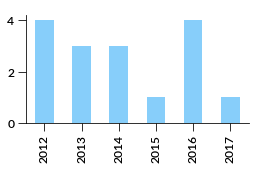

In [457]:
def make_chart(df,title=""):
    
    ret = df.copy()[years].transpose()
        
    ax = ret.plot.bar(figsize=(4,2))
    
    ax.set_title(title)
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.legend_.remove()
    
    plt.tight_layout()

        
    return ax


make_chart(town_year_growth[town_year_growth.index == "BETHEL"])

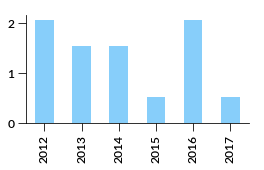

In [456]:
make_chart(town_year_rates[town_year_rates.index == "BETHEL"])

In [477]:
def make_both_charts(town):
    make_chart(town_year_growth[town_year_growth.index == town])
    plt.savefig("viz/img/abs/" + town + ".png",bbox_inches="tight")
    plt.close()

    make_chart(town_year_rates[town_year_rates.index == town])
    plt.savefig("viz/img/rate/" + town + ".png",bbox_inches="tight")
    plt.close()


In [478]:
make_both_charts("BETHEL")

In [479]:
all_towns = (town_year_growth.index.unique())
for t in all_towns:
    make_both_charts(t)

In [482]:
town_year_growth.join(town_year_rates,rsuffix="_rate").to_csv("viz/data/combined.csv")

### Race and ethnicity

Time permitting, a look at how the drug epidemic has affected different racial and ethnic groups

In [498]:
race_cols = ["race_eth","datetime"]
race_combined = pd.concat([OD[race_cols],OD2017[race_cols]])

In [499]:
# Make sure I didn't duplicate anything
race_combined["year"] = race_combined["datetime"].apply(lambda x: x.year)
race_combined.head()

,race_eth,datetime,year
0,White,2013-11-09,2013
1,White,2012-12-29,2012
2,White,2014-02-18,2014
3,White,2014-09-07,2014
4,White,2013-10-04,2013


In [500]:
len(race_combined[race_combined["year"] == 2017])

1038

In [501]:
# good

In [532]:
race_year_sum = race_combined.groupby(["race_eth","year"]).agg({"year":np.size})
race_year_sum.columns = ["count"]
race_year_sum = race_year_sum.reset_index().set_index("race_eth")
race_year_sum

,year,count
race_eth,,
Black,2012,38
Black,2013,44
Black,2014,27
Black,2015,46
Black,2016,86
Black,2017,88
Hispanic,2012,38
Hispanic,2013,52
Hispanic,2014,57


In [518]:
racedf2 = racedf[["Black, alone","White alone","Hispanic any"]]
racedf2.columns = "Black","White","Hispanic"
racedf2.transpose()

,CONNECTICUT
Black,347674.0
White,2464450.0
Hispanic,537728.0


In [535]:
race_rates = race_year_sum.join(racedf2.transpose())
race_rates.head()

,year,count,CONNECTICUT
Black,2012,38,347674.0
Black,2013,44,347674.0
Black,2014,27,347674.0
Black,2015,46,347674.0
Black,2016,86,347674.0


In [544]:
race_rates["rate"] = race_rates["count"] * 10000. / race_rates["CONNECTICUT"]
race_rates.reset_index().head()

,index,year,count,CONNECTICUT,rate
0,Black,2012,38,347674.0,1.092978
1,Black,2013,44,347674.0,1.265553
2,Black,2014,27,347674.0,0.776590
3,Black,2015,46,347674.0,1.323079
4,Black,2016,86,347674.0,2.473582


In [571]:
for_chart = pd.pivot_table(race_rates.reset_index(),columns="year",values="rate",index="index").loc[["Black","Hispanic","White"]]
print for_chart.transpose().to_csv(sep="\t",float_format='%.2f')

year	Black	Hispanic	White
2012	1.09	0.71	1.11
2013	1.27	0.97	1.57
2014	0.78	1.06	1.90
2015	1.32	1.47	2.39
2016	2.47	1.88	2.89
2017	2.53	2.27	3.30



In [572]:
for_chart = pd.pivot_table(race_rates.reset_index(),columns="year",values="count",index="index").loc[["Black","Hispanic","White"]]
print for_chart.transpose().to_csv(sep="\t",float_format='%.2f')

year	Black	Hispanic	White
2012	38	38	274
2013	44	52	388
2014	27	57	468
2015	46	79	589
2016	86	101	711
2017	88	122	813

